In [1]:
import json
import pandas as pd
import numpy as np
from typing import Any
from pathlib import Path

import matplotlib.pyplot as plt
from matplotlib import cm

In [2]:
def parse_results(path: str) -> pd.DataFrame:
    records = []
    with open(path, 'r') as f:
        buffer = []
        depth = 0

        for raw in f:
            line = raw.strip()
            if not line:
                continue  # skip blank lines

            # Track nesting of braces
            depth += line.count('{')
            depth -= line.count('}')

            buffer.append(raw)
            # If we’ve closed all opened braces, process one full JSON object
            if depth == 0 and buffer:
                chunk = ''.join(buffer)
                obj = json.loads(chunk)
                # same flattening logic as before
                for uid, details in obj.items():
                    params = details.pop('params')
                    flat = {'id': uid, **details}
                    for p, v in params.items():
                        if isinstance(v, list) and len(v) == 2:
                            flat[f'{p}_x'] = v[0]
                            flat[f'{p}_y'] = v[1]
                        else:
                            flat[p] = v
                    records.append(flat)
                buffer = []
    return pd.DataFrame(records)

In [3]:
def get_config(file_path: str):
    stem = Path(file_path).stem            
    config_name = stem.removeprefix("result_")      
    
    config_path = Path("configurations") / f"{config_name}.json"
    
    # 3) Open & load the JSON
    with config_path.open("r", encoding="utf-8") as f:
        config = json.load(f)
    return config

In [4]:
def collect_best_records(
    path,                # e.g. "results/"
    solver,              # substring to match in filename
    reconstruction_algo  # another substring to match
):
    path = Path(path)
    group = {}

    # 1) gather all matching files into `group[name] = df`
    for file_path in path.iterdir():
        if not file_path.is_file():
            continue
        name = file_path.name
        if solver in name and reconstruction_algo in name:
            # parse_results should return a DataFrame
            group[name] = parse_results(file_path)

    # 2) error if nothing matched
    if not group:
        raise Exception(
            f"No files found in {path!r} containing "
            f"{solver!r} AND {reconstruction_algo!r}"
        )

    # 3) build a config dict for each name
    config = { name: get_config(name) for name in group }

    # 4) for each df, pick the row(s) with max score and merge in config
    best_slices = []
    for name, df in group.items():
        # select best‐score rows
        best_df = df[df['score'] == df['score'].min()].copy()

        # grab the config dict for this experiment
        conf = config[name]
        # turn it into a DataFrame with same index, then concat
        conf_df = pd.DataFrame([conf] * len(best_df), index=best_df.index)

        merged = pd.concat([best_df.reset_index(drop=True),
                            conf_df.reset_index(drop=True)],
                           axis=1)
        best_slices.append(merged)

    # 5) stitch all best‐records together
    result = pd.concat(best_slices, ignore_index=True)
    return result


In [5]:
reconstruction_algo = "ST"
solver="PolyHoot"

df_best = collect_best_records("results/", solver, reconstruction_algo)
df_best.head()

,id,score,total_ghosts,overall_ghost_rate,event_avg_ghost_rate,clone_percentage,total_tracks,time,scatter,min_strong_track_length,allowed_missed_modules,solverName,reconstruction_algo,num_events,intra_node,max_runs,optimizer
0,3ddeeab4-7b50-4838-9894-ab8c83bfd348,15902.729728,1098,3.452613,2.957095,5.749332,31802,0.342109,0.015625,5.0,4.0,PolyHoot,ST,100,True,1000,"{'max_iterations': 1000, 'objective': 'min', '..."
1,a584e130-a71d-470c-8ee3-2250d0daf73c,9541.398158,1098,3.452613,2.957095,5.749332,31802,0.269089,0.015625,5.0,4.0,PolyHoot,ST,100,True,1000,"{'max_iterations': 1000, 'objective': 'min', '..."
2,eb4a88af-5f38-46f9-8f5b-31b409a76b94,15902.063344,1098,3.452613,2.957095,5.749332,31802,0.275599,0.015625,5.0,4.0,PolyHoot,ST,100,True,1000,"{'max_iterations': 1000, 'objective': 'min', '..."
3,5f751af0-e796-4e35-92f5-925aef884a9f,15901.794817,1098,3.452613,2.957095,5.749332,31802,0.260736,0.015625,5.0,4.0,PolyHoot,ST,100,True,1000,"{'max_iterations': 1000, 'objective': 'min', '..."


In [6]:
def collect_all_records(
    path,                # e.g. "results/"
    solver,              # substring to match in filename
    reconstruction_algo  # another substring to match
):
    path = Path(path)
    group = {}

    # 1) gather all matching files into `group[name] = df`
    for file_path in path.iterdir():
        if not file_path.is_file():
            continue
        name = file_path.name
        if solver in name and reconstruction_algo in name:
            # parse_results should return a DataFrame
            group[name] = parse_results(file_path)

    # 2) error if nothing matched
    if not group:
        raise Exception(
            f"No files found in {path!r} containing "
            f"{solver!r} AND {reconstruction_algo!r}"
        )

    # 3) build a config dict for each name
    config = { name: get_config(name) for name in group }

    # 4) for each df, attach all rows + filename + config
    all_slices = []
    for name, df in group.items():
        df_full = df.copy()

        # add a column so we know which file this row came from
        df_full['filename'] = name

        # grab the config dict for this experiment
        conf = config[name]
        # turn it into a DataFrame with same length, then concat
        conf_df = pd.DataFrame([conf] * len(df_full), index=df_full.index)

        merged = pd.concat([
            df_full.reset_index(drop=True),
            conf_df.reset_index(drop=True)
        ], axis=1)

        all_slices.append(merged)

    # 5) stitch everything together
    result = pd.concat(all_slices, ignore_index=True)
    return result

In [7]:
df_all = collect_all_records("results/", solver, reconstruction_algo)

In [8]:
def plot_score_scatter_by_params(
    df,
    x_param,
    y_param,
    annotate_cols=None,           # which df columns to show in the box
    annotate_markers=None,        # footnote symbols, e.g. ['1','2'] or [r'$\alpha$',r'$\beta$']
    col_labels=None,              # optional mapping { raw_col_name: "Pretty Name" }
    figsize=(8, 5),
    marker='o',
    alpha=0.8,
    title_fontsize=18,
    label_fontsize=14,
    tick_fontsize=12,
    dpi=300,
    title="INSERT A TITLE",
    XTitle="INSERT",
    YTitle="INSERT"
):
    """
    Scatter plot of two hyperparams.  Points with min-x and min-y get little
    footnote markers, and on the right you see:

      marker:
         Pretty Col 1: value
         Pretty Col 2: value
    """
    annotate_cols    = annotate_cols    or []
    annotate_markers = annotate_markers or ['1','2']
    col_labels       = col_labels       or {}

    # --- styling (unchanged) ---
    plt.rcParams.update({
        "font.family":       "serif",
        "font.serif":        ["Times New Roman","Palatino","serif"],
        "axes.titlesize":    title_fontsize,
        "axes.labelsize":    label_fontsize,
        "xtick.labelsize":   tick_fontsize,
        "ytick.labelsize":   tick_fontsize,
        "figure.dpi":        dpi,
        "axes.grid":         True,
        "grid.color":        "#999999",
        "grid.alpha":        0.2,
        "grid.linestyle":    "--"
    })

    fig, ax = plt.subplots(figsize=figsize)
    ax.scatter(df[x_param], df[y_param], marker=marker, alpha=alpha)
    ax.set_title(title, pad=10)
    ax.set_xlabel(XTitle)
    ax.set_ylabel(YTitle)
    if df[x_param].nunique()>10:
        plt.setp(ax.get_xticklabels(), rotation=45, ha='right')
    if df[y_param].nunique()>10:
        plt.setp(ax.get_yticklabels(), rotation=45, va='top')

    # locate the two “special” rows
    specials = [
        ('min x', df[x_param].idxmin()),
        ('min y', df[y_param].idxmin())
    ]

    # place superscript‐style markers just off each point
    for i, (_, idx) in enumerate(specials):
        x0, y0 = df.loc[idx, x_param], df.loc[idx, y_param]
        sym     = annotate_markers[i]
        ax.annotate(
            sym,
            xy=(x0,y0),
            xytext=(3,3),
            textcoords='offset points',
            fontsize=label_fontsize-2,
            ha='left', va='bottom'
        )

    # build the right-side info box
    info_lines = []
    for i, (label, idx) in enumerate(specials):
        sym = annotate_markers[i]
        # first line: just the marker + colon
        info_lines.append(f"{sym}:")
        # then each requested column underneath
        for col in annotate_cols:
            pretty = col_labels.get(col, col)
            val    = df.loc[idx, col]
            info_lines.append(f"    {pretty}: {val}")
        info_lines.append("")   # blank line to separate entries

    info_text = "\n".join(info_lines).rstrip()

    # make room on the right and drop the box in
    fig.subplots_adjust(right=0.75)
    ax.text(
        1.01, 0.5, info_text,
        transform=ax.transAxes,
        fontsize=label_fontsize-2,
        va='center', ha='left'
    )

    plt.tight_layout()
    plt.show()


In [9]:
if reconstruction_algo == "TF":
    annotate_cols=[
            "max_slope_x",
            "max_slope_y",
            "max_tol_x",
            "max_tol_y",
            "scatter"
        ] #TF

    col_labels = {
        'max_slope_x': r'$\Theta_x$',   # x‐slope angle
        'max_slope_y': r'$\Theta_y$',   # y‐slope angle
        'max_tol_x':   r'$\tau_x$',     # x‐tolerance
        'max_tol_y':   r'$\tau_y$',     # y‐tolerance
        'scatter':     r'$\sigma$'      # arbitrary scatter parameter
    } # TF
else:
    annotate_cols=[
            "min_strong_track_length",
            "allowed_missed_modules",
            "scatter"
        ] #ST

    col_labels = {
        'min_strong_track_length': r'$\ell_{\mathrm{strong}}^{\min}$',
        'allowed_missed_modules':   r'$n_{\mathrm{miss}}$',
        'scatter':                  r'$\sigma$'
    }


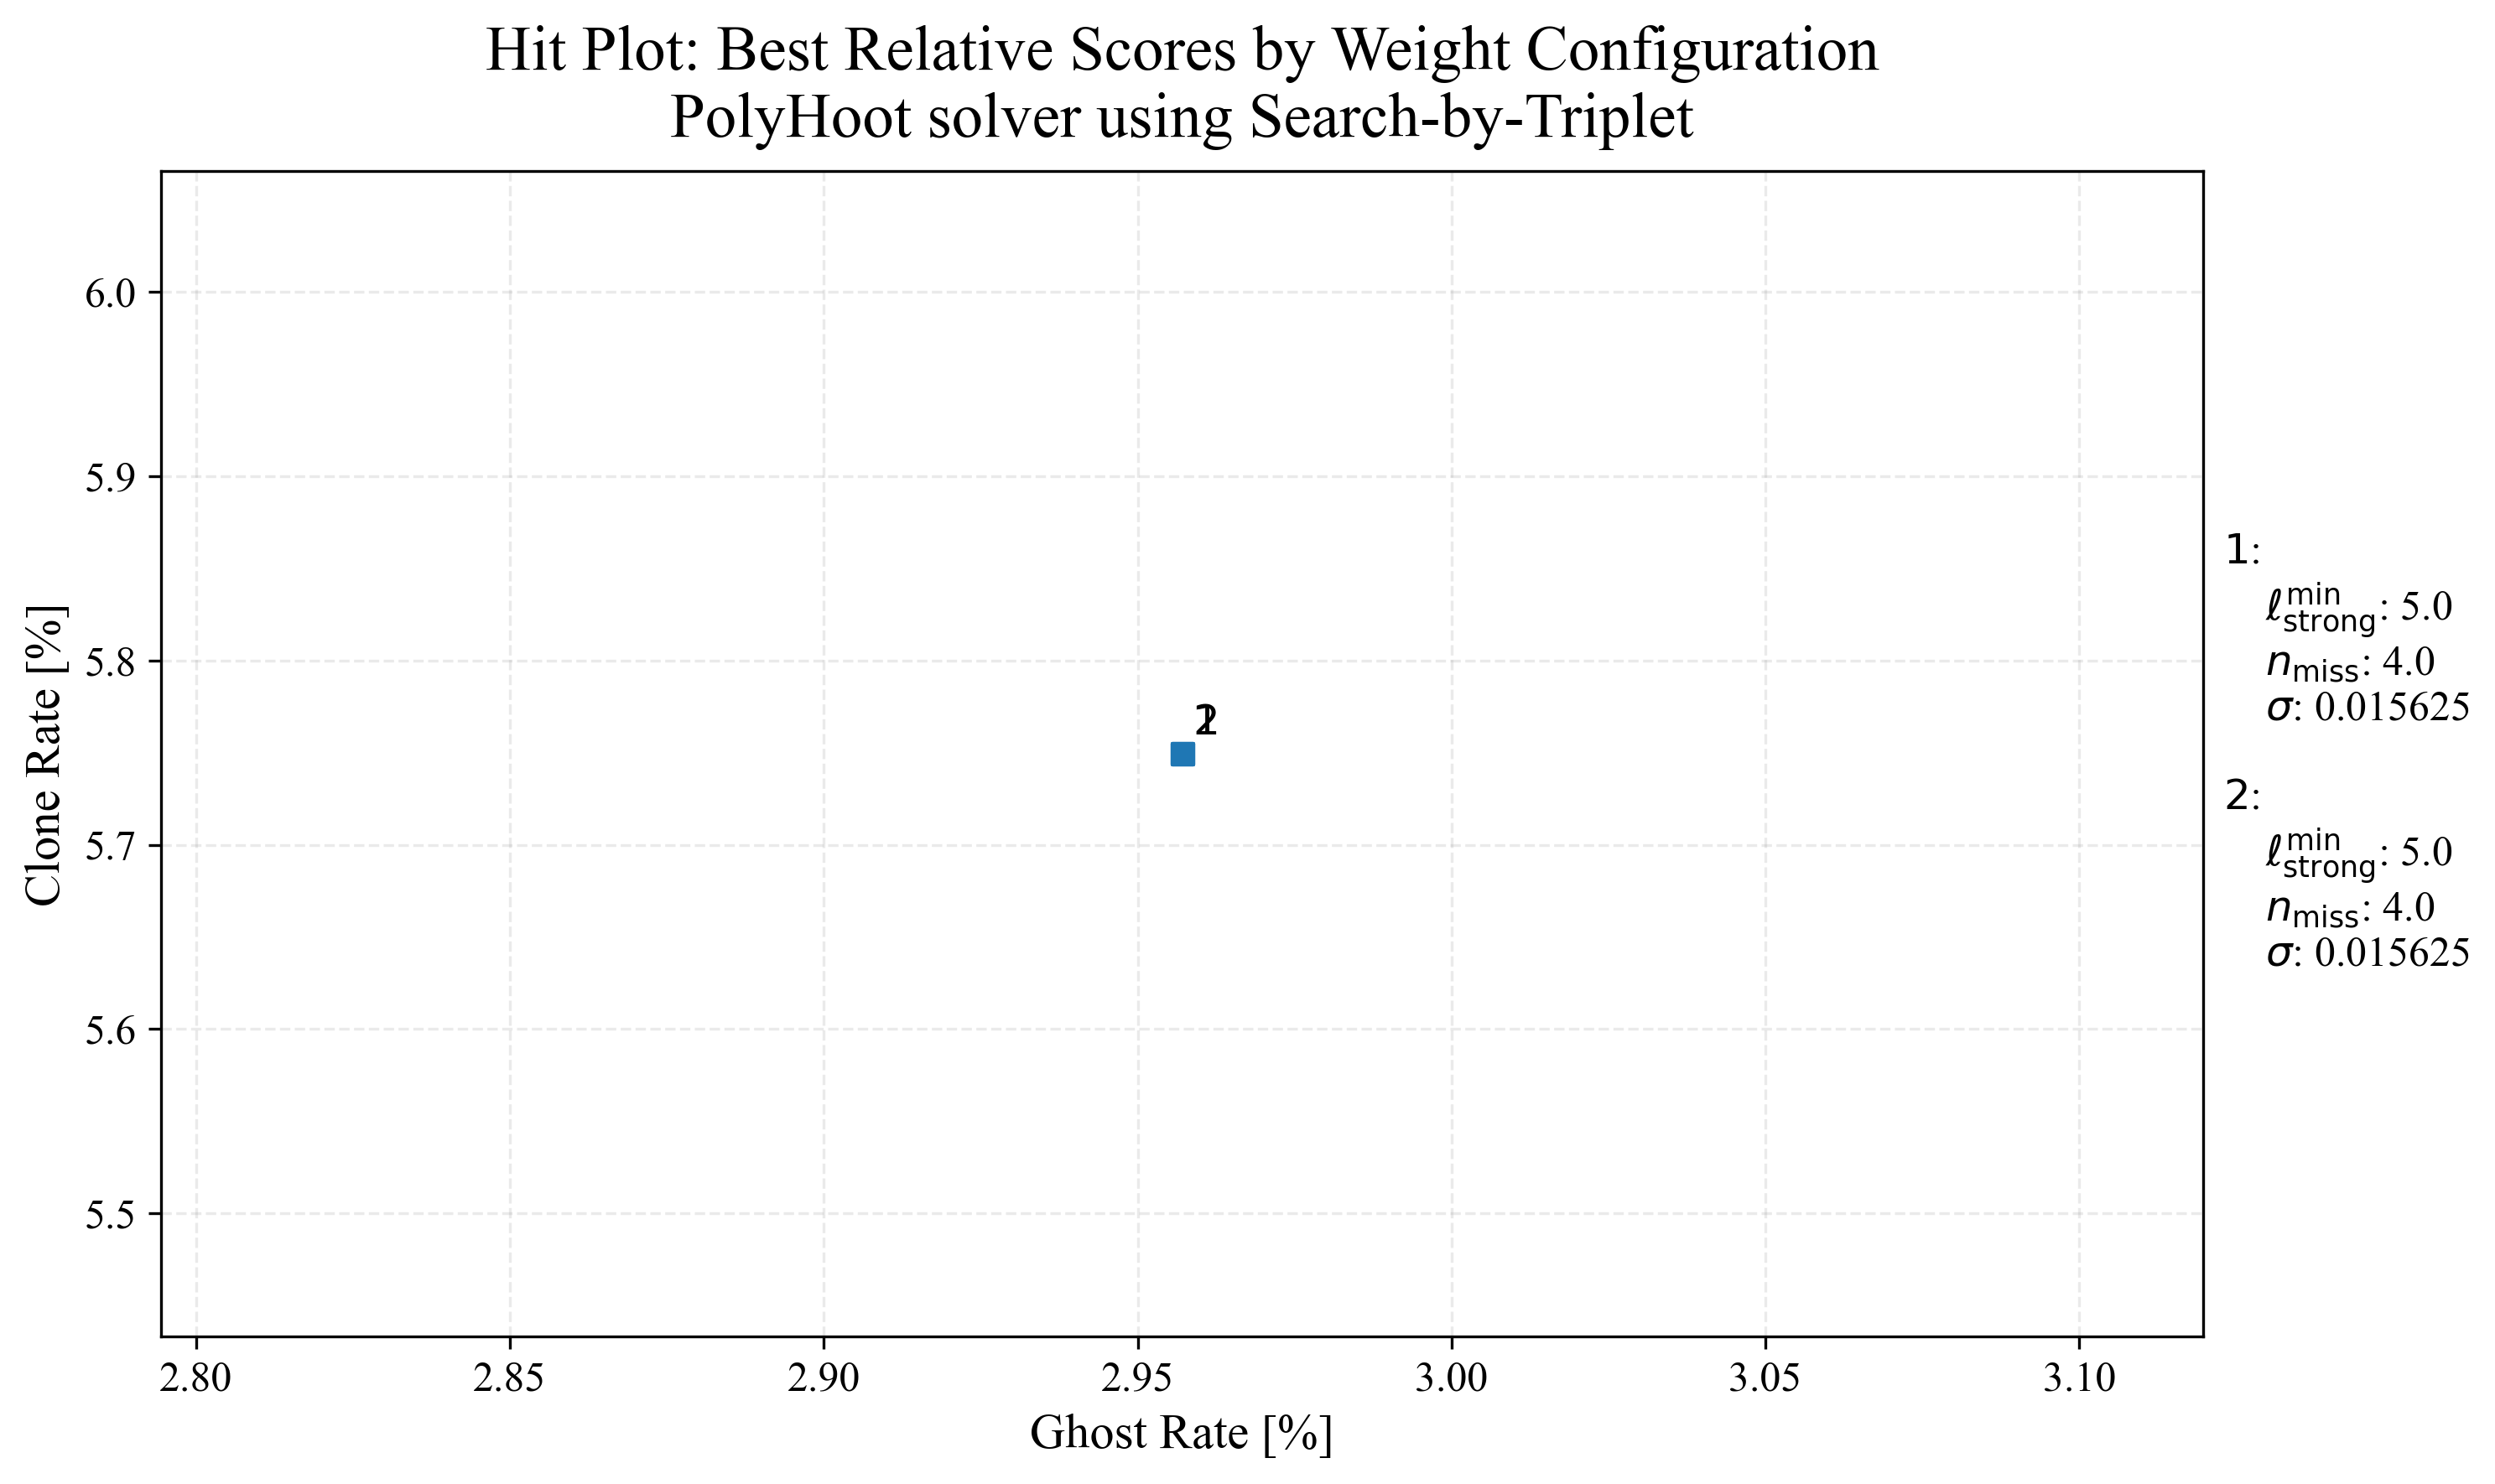

In [10]:
plot_score_scatter_by_params(
    df_best,
    x_param='event_avg_ghost_rate',
    y_param='clone_percentage',
    annotate_cols=annotate_cols,
    col_labels=col_labels,
    annotate_markers=[r'$1$', r'$2$'],
    figsize=(10, 6),
    marker='s',
    title=f"Hit Plot: Best Relative Scores by Weight Configuration\n{solver} solver using {'Track-Following' if reconstruction_algo == 'TF' else 'Search-by-Triplet'}",
    XTitle="Ghost Rate [%]",
    YTitle="Clone Rate [%]"
)



In [11]:
df_best.head()

,id,score,total_ghosts,overall_ghost_rate,event_avg_ghost_rate,clone_percentage,total_tracks,time,scatter,min_strong_track_length,allowed_missed_modules,solverName,reconstruction_algo,num_events,intra_node,max_runs,optimizer
0,3ddeeab4-7b50-4838-9894-ab8c83bfd348,15902.729728,1098,3.452613,2.957095,5.749332,31802,0.342109,0.015625,5.0,4.0,PolyHoot,ST,100,True,1000,"{'max_iterations': 1000, 'objective': 'min', '..."
1,a584e130-a71d-470c-8ee3-2250d0daf73c,9541.398158,1098,3.452613,2.957095,5.749332,31802,0.269089,0.015625,5.0,4.0,PolyHoot,ST,100,True,1000,"{'max_iterations': 1000, 'objective': 'min', '..."
2,eb4a88af-5f38-46f9-8f5b-31b409a76b94,15902.063344,1098,3.452613,2.957095,5.749332,31802,0.275599,0.015625,5.0,4.0,PolyHoot,ST,100,True,1000,"{'max_iterations': 1000, 'objective': 'min', '..."
3,5f751af0-e796-4e35-92f5-925aef884a9f,15901.794817,1098,3.452613,2.957095,5.749332,31802,0.260736,0.015625,5.0,4.0,PolyHoot,ST,100,True,1000,"{'max_iterations': 1000, 'objective': 'min', '..."


## Lets create parento front

In [20]:
import numpy as np
import matplotlib.pyplot as plt

def plot_pareto(
    df,
    x_param,
    y_param,
    annotate_cols=None,
    annotate_markers=None,
    col_labels=None,
    degree=1,
    figsize=(8, 5),
    marker='o',
    alpha=0.8,
    title_fontsize=18,
    label_fontsize=14,
    tick_fontsize=12,
    dpi=300,
    title="Pareto Scatter with Regression",
    XTitle="X",
    YTitle="Y",
    pareto_color='C1',            # contrasting color for Pareto front (default: orange)
    regression_color='red',       # color for regression line
    regression_label=None,
    XMAX=100,
    YMAX=100
):
    """
    Scatter plot with Pareto front regression.
    - Computes the Pareto front (non-dominated points assuming minimization on both axes).
    - Highlights the Pareto frontier in `pareto_color` for easy contrast with blue data points.
    - Fits a polynomial regression of given degree on the Pareto frontier.
    - Annotates the single point with minimal sum of X + Y.
    """
    annotate_cols    = annotate_cols    or []
    annotate_markers = annotate_markers or ['*']
    col_labels       = col_labels       or {}

    # --- styling ---
    plt.rcParams.update({
        "font.family":       "serif",
        "font.serif":        ["Times New Roman","Palatino","serif"],
        "axes.titlesize":    title_fontsize,
        "axes.labelsize":    label_fontsize,
        "xtick.labelsize":   tick_fontsize,
        "ytick.labelsize":   tick_fontsize,
        "figure.dpi":        dpi,
        "axes.grid":         True,
        "grid.color":        "#999999",
        "grid.alpha":        0.2,
        "grid.linestyle":    "--"
    })

    # Extract data and compute Pareto front
    data = df[[x_param, y_param]].values
    sorted_idx = np.argsort(data[:, 0])
    pareto_front = []
    best_y = np.inf
    for idx in sorted_idx:
        x_val, y_val = data[idx]
        if y_val < best_y:
            pareto_front.append(idx)
            best_y = y_val
    pareto_idx = np.array(pareto_front, dtype=int)

    pf_x = data[pareto_idx, 0]
    pf_y = data[pareto_idx, 1]

    # Fit regression on Pareto front
    coeffs = np.polyfit(pf_x, pf_y, deg=degree)
    poly = np.poly1d(coeffs)

    # Identify the point minimizing X+Y
    sum_series = df[x_param] + df[y_param]
    best_idx = sum_series.idxmin()

    # Prepare plot
    fig, ax = plt.subplots(figsize=figsize)
    # scatter data points (default blue)
    ax.scatter(df[x_param], df[y_param], marker=marker, alpha=alpha, label='Data points')
    # Pareto frontier in contrasting color
    ax.plot(pf_x, pf_y, linestyle='--', color=pareto_color, label='Pareto front', alpha=0.7)

    # Annotate the best-sum point
    sym = annotate_markers[0]
    x0, y0 = df.loc[best_idx, x_param], df.loc[best_idx, y_param]
    ax.annotate(
        sym,
        xy=(x0, y0),
        xytext=(-13, -13),
        textcoords='offset points',
        fontsize=label_fontsize-2,
        ha='left',
        va='bottom'
    )

    # Build and place info box
    info_lines = [f"{sym}:"]
    for col in annotate_cols:
        pretty = col_labels.get(col, col)
        val = df.loc[best_idx, col]
        info_lines.append(f"    {pretty}: {val}")
    info_text = "\n".join(info_lines)
    fig.subplots_adjust(right=0.75)
    ax.text(
        1.02, 0.5, info_text,
        transform=ax.transAxes,
        fontsize=label_fontsize-2,
        va='center', ha='left'
    )

    # Final touches
    ax.set_xlabel(XTitle)
    ax.set_ylabel(YTitle)
    ax.set_title(title)
    ax.set_xlim(0, XMAX)
    ax.set_ylim(0, YMAX)
    ax.legend(loc='upper right')
    plt.tight_layout()
    plt.show()


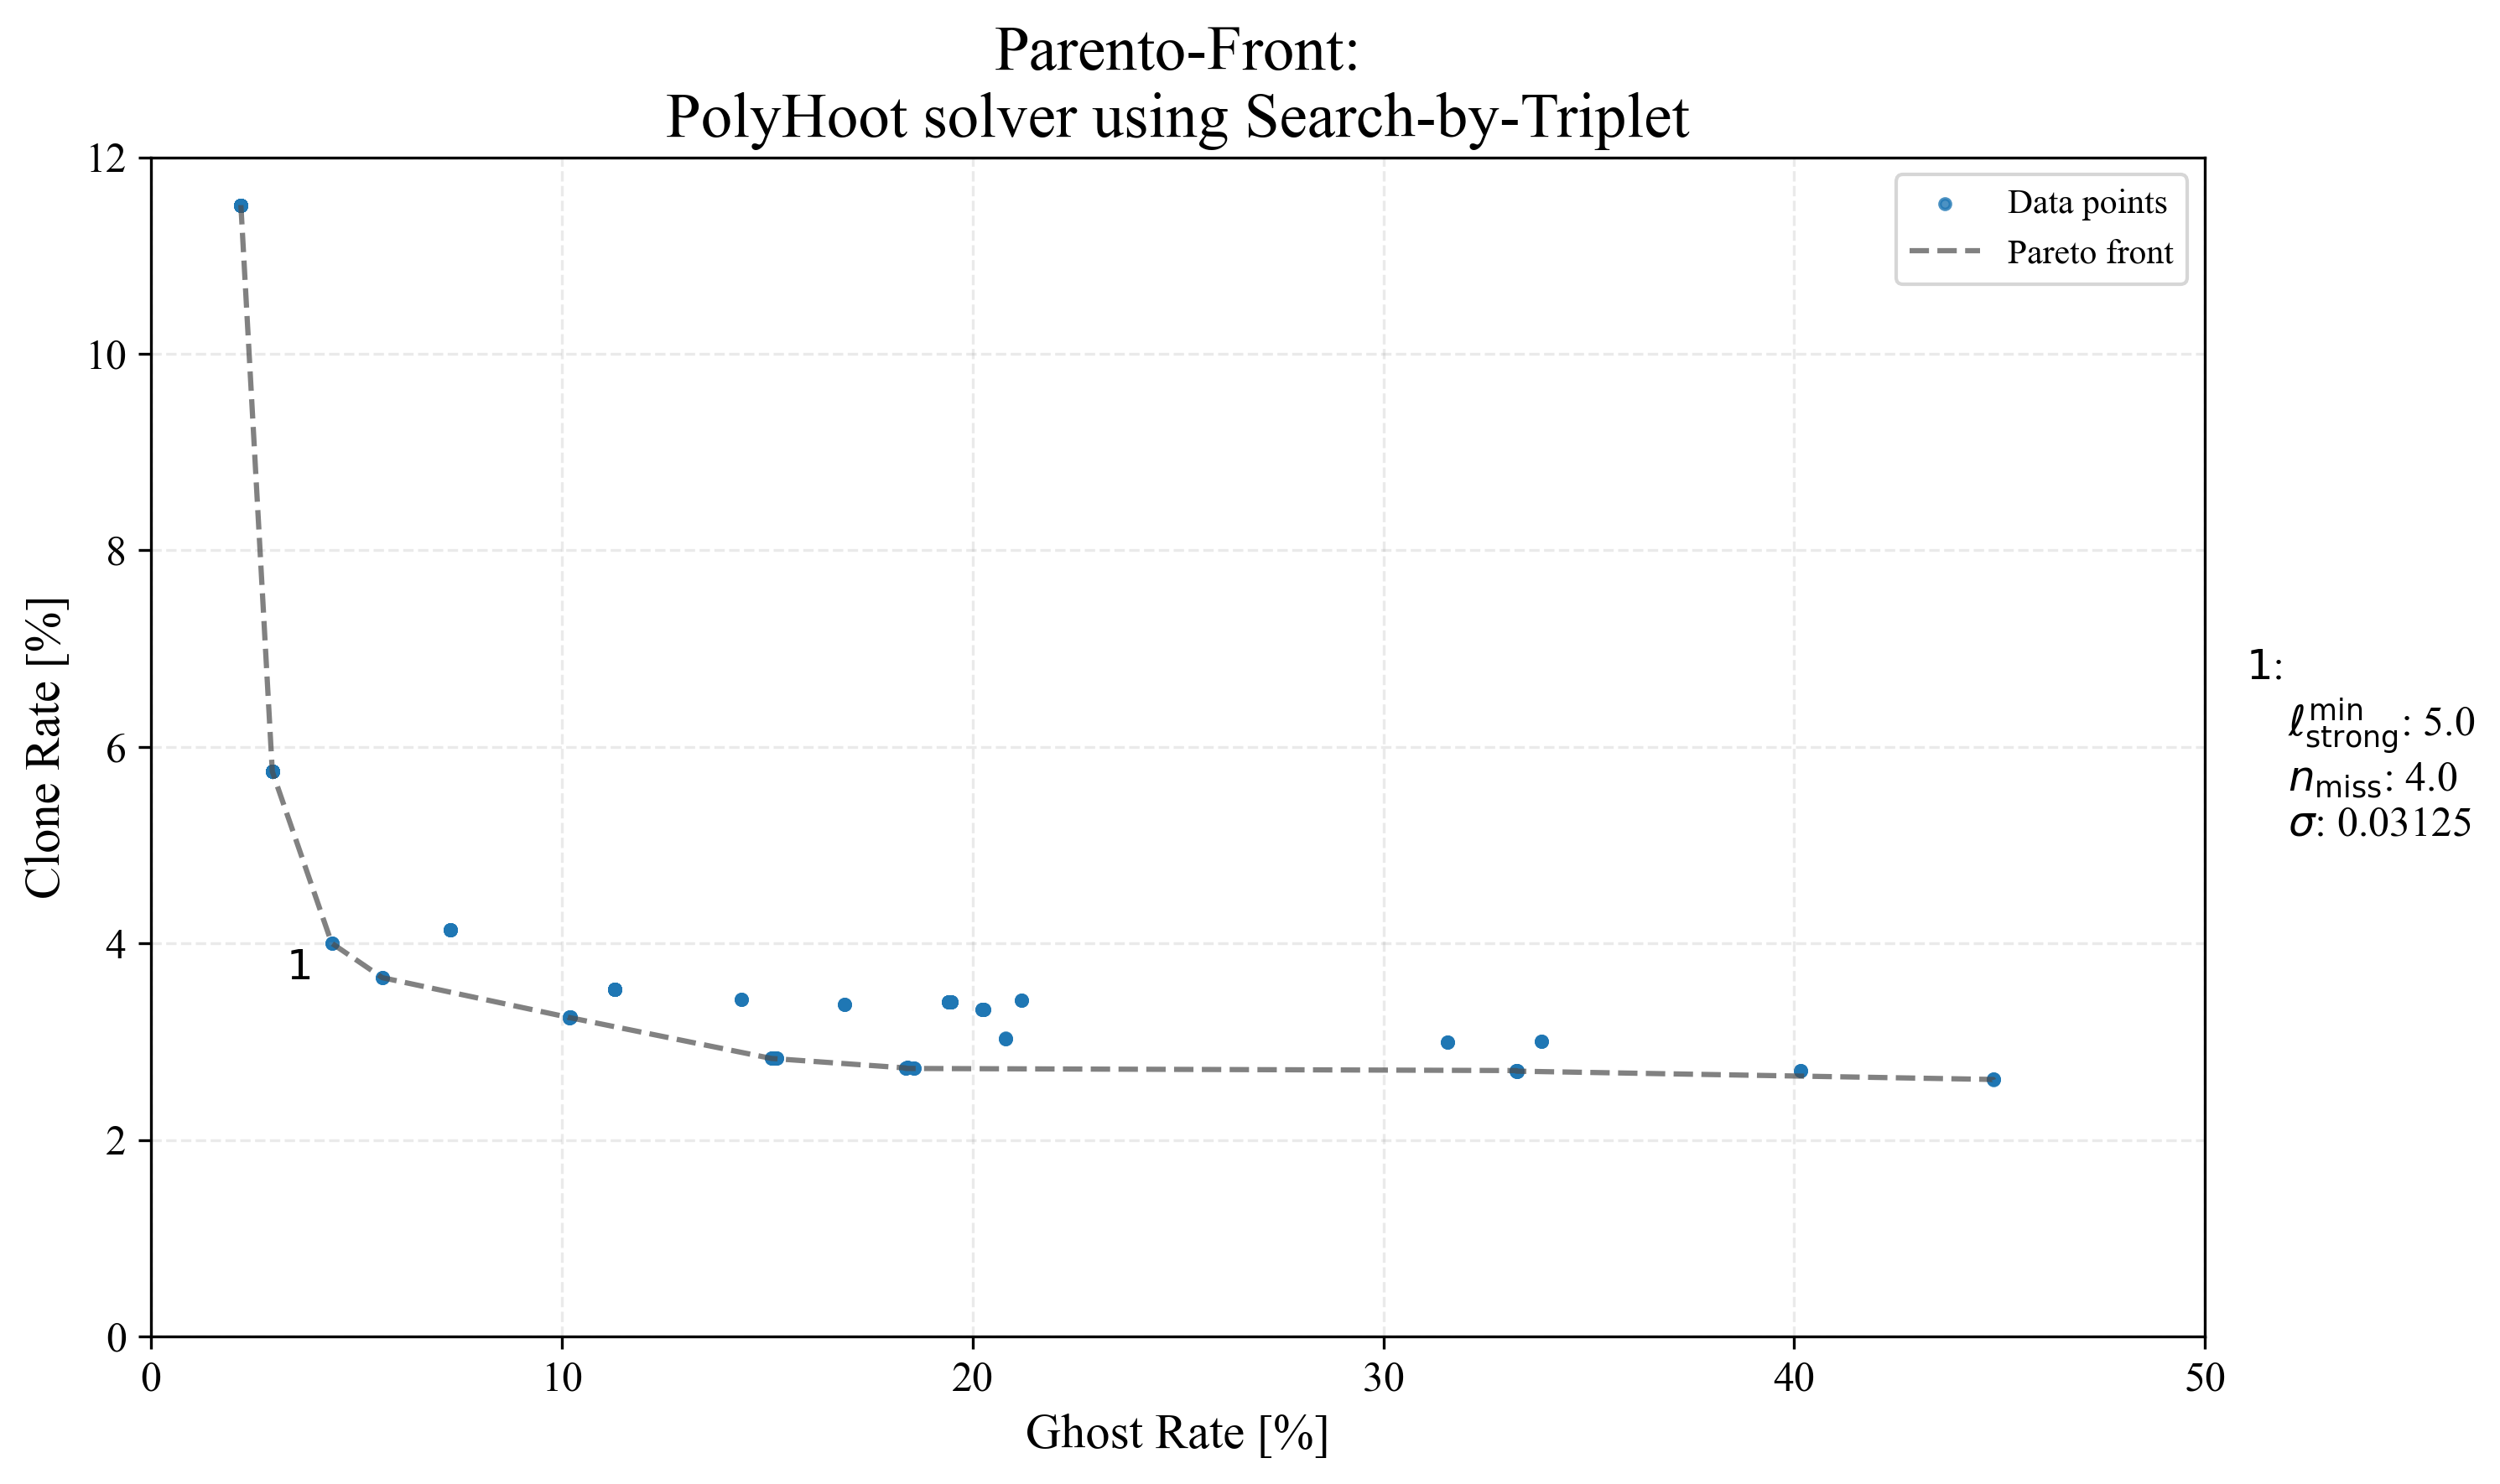

In [21]:
plot_pareto(
    df_all,
    x_param='event_avg_ghost_rate',
    y_param='clone_percentage',
    annotate_cols=annotate_cols,
    col_labels=col_labels,
    annotate_markers=[r'$1$', r'$2$'],
    figsize=(10, 6),
    marker='.',
    title=f"Parento-Front:\n{solver} solver using {'Track-Following' if reconstruction_algo == 'TF' else 'Search-by-Triplet'}",
    XTitle="Ghost Rate [%]",
    YTitle="Clone Rate [%]",
    pareto_color="#4C4C4C",
    XMAX=50,
    YMAX=12
)

In [14]:
test = df_all.drop(columns=["optimizer"]).drop_duplicates(inplace=False)


In [15]:
test.drop_duplicates(inplace=True)

In [16]:
test.shape

(4000, 17)